In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16374991.83it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 535650.24it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4463581.74it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3858725.70it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
def num_correct(output, target):

  _ , pred = torch.max(output, dim = 1)

  return torch.sum(pred == target).item()

In [ ]:
def train(model, batch, crit, optim, train_data):

  train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)

  tot_loss= 0.0
  tot_corr = 0

  for _ , (images, targets) in enumerate(train_loader):
    optim.zero_grad()
    output = model(images)
    loss = crit(output, targets)
    loss.backward()
    tot_loss += loss.item()
    tot_corr += num_correct(output, targets)
    optim.step()

  accuracy = tot_corr / len(train_data)

  return tot_loss, accuracy

In [ ]:
def test(model, crit, batch, test_data):

  test_loader = DataLoader(test_data, batch_size=batch, shuffle=True)

  tot_loss = 0.0
  tot_corr = 0

  for _ , (images, targets) in enumerate(test_loader):
    output = model(images)
    loss = crit(output, targets)
    tot_loss += loss.item()
    tot_corr += num_correct(output, targets)

  accuracy = tot_corr / len(test_data)

  return tot_loss, accuracy

In [ ]:
def findFrobeniusNorm(model):

  norm = 0.0

  for param in model.parameters():
    norm += torch.sum(param.grad ** 2)

  return norm.item() ** 0.5

In [ ]:
class Model(nn.Module):

  def __init__(self, hid_nodes=256):
    super().__init__()
    self.fc1 = nn.Linear(784, hid_nodes)
    self.fc2 = nn.Linear(hid_nodes, hid_nodes)
    self.output = nn.Linear(hid_nodes, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = self.output(x)
    return F.log_softmax(x, dim=1)

In [ ]:
batch_list = [10, 100, 1000, 10000, 30000]
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
sens_list = []

In [ ]:
for batch in batch_list:

  model = Model()
  crit = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_loss, train_acc = train(model, batch, crit, optimizer, train_data)
  sens = findFrobeniusNorm(model)
  test_loss, test_acc = test(model, crit, batch, test_data)

  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  sens_list.append(sens)


In [ ]:
for ind in range(len(batch_list)):

  batch_list[ind] = np.log10(batch_list[ind])

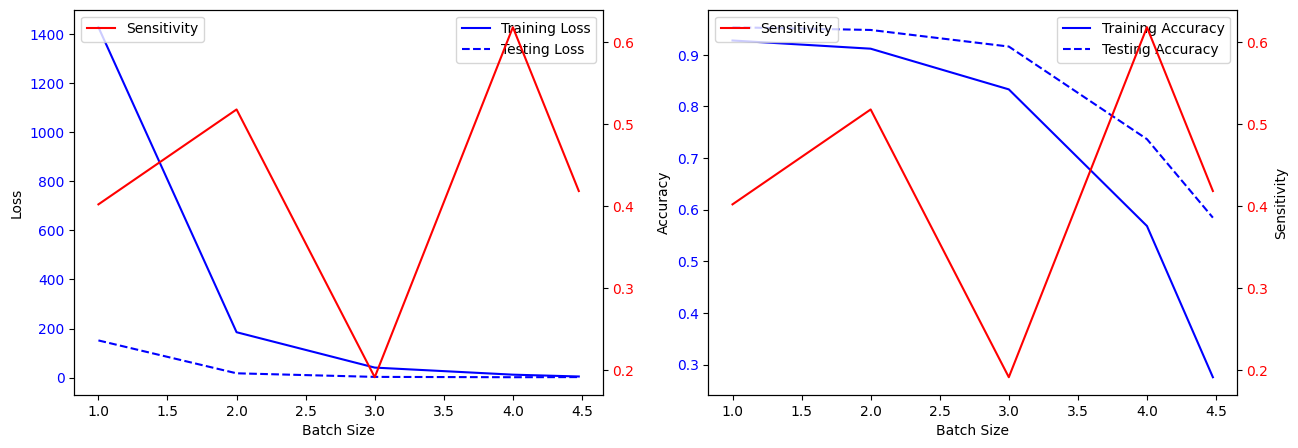

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(batch_list, train_loss_list, color='blue', label='Training Loss')
ax1.plot(batch_list, test_loss_list, color='blue', linestyle='--', label='Testing Loss')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Loss')
ax1.tick_params(axis ='y', labelcolor='blue')
ax1.legend()
ax3 = ax1.twinx()
ax3.plot(batch_list, sens_list, color='red', label='Sensitivity')
ax3.tick_params(axis='y', labelcolor='red')
ax3.legend()

ax2.plot(batch_list, train_acc_list, color='blue', label='Training Accuracy')
ax2.plot(batch_list, test_acc_list, color='blue', linestyle='--', label='Testing Accuracy')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis ='y', labelcolor='blue')
ax2.legend()
ax4 = ax2.twinx()
ax4.plot(batch_list, sens_list, color='red', label='Sensitivity')
ax4.set_ylabel('Sensitivity')
ax4.tick_params(axis='y', labelcolor='red')
ax4.legend()

plt.show()